# Import the Libraries

In [273]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure
from skimage import feature

from pandas import read_excel

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score


## HOG Feature Extraction

In [274]:
from IPython.display import clear_output

def get_feature_vector(image_directory, grid_q= 4, orientation= 8, edge= False):
    img= cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE)
    if edge== True:
        img= cv2.Canny(img, 100, 200)

    if type(grid_q)== np.ndarray: # ndarray path
        hog_features= []
        for gq in grid_q:
            hf= get_feature_vector(img_dir, grid_q= gq, orientation= 10, edge= False)
            hog_features= np.append(hog_features, hf)
    else: # integer path
        ppc= (int(img.shape[0]/grid_q), int(img.shape[1]/grid_q))
        hog_features= hog(img, orientations= 12, pixels_per_cell= (int(img.shape[0]/grid_q), int(img.shape[1]/grid_q)),
                        cells_per_block=(1, 1), feature_vector= True)

    return hog_features

feature_matrix= []
img_directories= []
for i in range(1, 1500):
    img_dir= "./pictures/" + str(i) + ".png"
    try:        
        feature_vec= get_feature_vector(img_dir, grid_q= 4, orientation= 10, edge= False)
        # feature_vec= get_feature_vector(img_dir, grid_q= np.arange(1, 5), orientation= 10, edge= False)

        feature_matrix.append(feature_vec)
        img_directories.append(img_dir)
    except:
        pass


clear_output()
feature_matrix= np.array(feature_matrix)
img_directories= np.array(img_directories)

print(f"Total feature count: {feature_matrix.shape[1]}")

zero_ratio= 1 - np.count_nonzero(feature_matrix)/feature_matrix.size 
print(f"Zero feature ratio: {100*zero_ratio:.1f}%", )

unique_feature, c_unique_feature= np.unique(feature_matrix, return_counts= True)
unique_ratio= 1 - np.sum(np.sort(c_unique_feature[c_unique_feature!= 1]))/feature_matrix.size 
print(f"Unique feature ratio: {100*unique_ratio:.1f}%")

Total feature count: 192
Zero feature ratio: 2.3%
Unique feature ratio: 62.1%


### Scale & PCA

Initial features: 192 Final features: 5


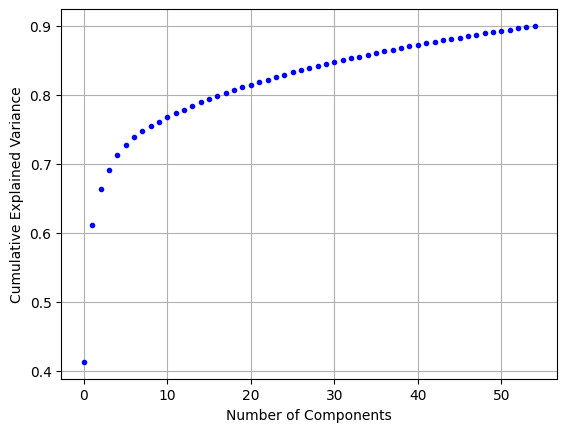

In [275]:
scaler= StandardScaler()
feature_matrix= scaler.fit_transform(feature_matrix)

pca= PCA()
principal_components= pca.fit_transform(feature_matrix)
var_csum= np.cumsum(pca.explained_variance_ratio_)
plt.plot(var_csum[var_csum < .9], "b .")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()

principal_components= pca.fit_transform(feature_matrix)
required_variance= .7
no_components= sum(pca.explained_variance_ratio_.cumsum() < required_variance) + 1

pca_var= PCA(no_components)
principal_matrix= pca_var.fit_transform(feature_matrix)

with open("./pictures/labels.csv") as f:
    l= f.read()
    try: # Mac
        int(l[1:2])
        l= l[1:]
    except: # Windows
        l= l[3:]
    
    labels= np.array(l.split(), dtype= int)

labels= labels[0:feature_matrix.shape[0]]

nonzero_index= labels!= 0
labels= labels[nonzero_index]
principal_matrix= principal_matrix[nonzero_index]
print(f"Initial features: {feature_matrix.shape[1]} Final features: {principal_matrix.shape[1]}")


### Support Vector Regressor & Hyperparameter Tuning

In [276]:
X_train, X_test, y_train, y_test, i_train, i_test= train_test_split(principal_matrix, labels, np.arange(labels.size), test_size= .3, random_state= 0)

svr= SVR()

param_grid= [
  {"kernel": ["linear"], "C": [.1, 1, 10, 100]},
  {"kernel": ["rbf"], "C": [1, 10, 100, 1000], "gamma": [1, .1, .01, .001, 0.0001]}
 ]

param_grid= [
  {"kernel": ["rbf"], "C": [100], "gamma": [.01]}
 ]

model= GridSearchCV(svr, param_grid= param_grid, verbose= True)

model.fit(X_train, y_train)
print(model.best_params_)
# print(model.cv_results_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [277]:
y_pred= model.predict(X_test)

mae= mean_absolute_error(y_test, y_pred)
r2= r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error: 10.198
R^2 Score: 0.825


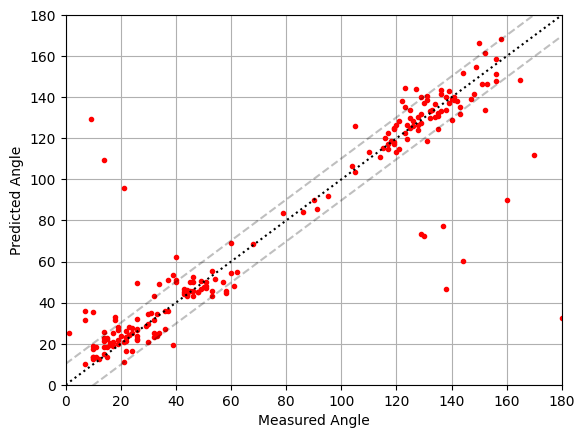

In [278]:
plt.plot(y_test, y_pred, "r.")
plt.plot(np.arange(0, 180), np.arange(0, 180), "k:")
plt.plot(np.arange(0, 180), np.arange(0, 180)-mae, "k--", alpha= .25)
plt.plot(np.arange(0, 180), np.arange(0, 180)+mae, "k--", alpha= .25)

plt.xlabel("Measured Angle")
plt.ylabel("Predicted Angle")
plt.axis([0, 180, 0, 180])
plt.grid()

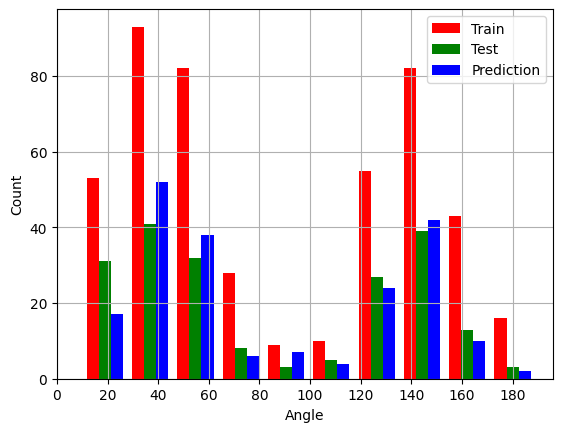

In [279]:
plt.hist([y_train, y_test, y_pred], color= ["r", "g", "b"], align= "right")
plt.xticks(np.arange(0, 181, 20))
plt.ylabel("Count")
plt.xlabel("Angle")
plt.legend(["Train", "Test", "Prediction"])
plt.grid()


Max error at i_abs= 622, measured: 180, predicted: 32.43, error= 147.57
Max error at i_abs= 641, measured: 9, predicted: 129.48, error= 120.48
Max error at i_abs= 652, measured: 14, predicted: 109.26, error= 95.26
Max error at i_abs= 122, measured: 138, predicted: 46.51, error= 91.49
Max error at i_abs= 140, measured: 144, predicted: 60.34, error= 83.66
Max error at i_abs= 374, measured: 21, predicted: 95.89, error= 74.89


Text(0.5, 0.98, 'Max Errors')

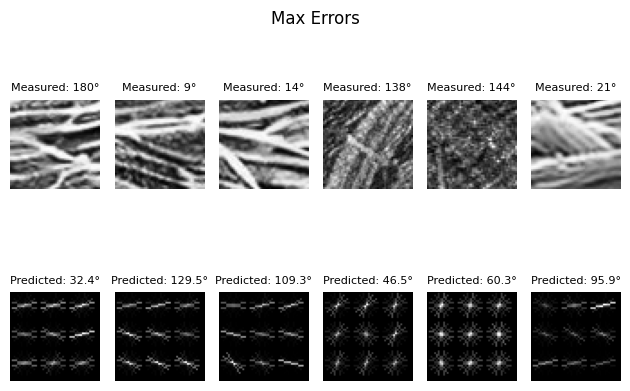

In [280]:
y_error= abs(y_pred-y_test)
y_error_sorted= np.sort(y_error)[::-1]
no_pics= 6

fig, axs = plt.subplots(2, no_pics)

for i in np.arange(0, no_pics):
    i_max_error= np.where(y_error== y_error_sorted[i])[0]
    i_abs= i_test[i_max_error][0]

    print(f"Max error at i_abs= {i_abs}, measured: {y_test[i_max_error][0]}, predicted: {y_pred[i_max_error][0]:.2f}, error= {y_error_sorted[i]:.2f}")

    img_dir= img_directories[i_abs]
    img= cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    hog_features, hog_image = hog(img, orientations= 8, pixels_per_cell= (int(img.shape[0]/3), int(img.shape[1]/3)),
                        visualize=True, feature_vector= True)


    plt.subplot(2, no_pics, i+1)
    plt.imshow(img, cmap= "gray")
    #plt.title("Original Image")
    plt.axis("off")
    plt.title(f"Measured: {y_test[i_max_error][0]}{chr(176)}", size= 8)

    plt.subplot(2, no_pics, i+1 + no_pics)
    plt.imshow(hog_image, cmap='gray')
    #plt.title("HOG Image")
    plt.axis("off")
    plt.title(f"Predicted: {y_pred[i_max_error][0]:.1f}{chr(176)}", size= 8)

plt.tight_layout()
plt.suptitle("Max Errors")


Max error at i_abs= 477, measured: 126, predicted: 125.98, error= 0.02
Max error at i_abs= 492, measured: 90, predicted: 89.96, error= 0.04
Max error at i_abs= 18, measured: 44, predicted: 43.94, error= 0.06
Max error at i_abs= 332, measured: 125, predicted: 124.94, error= 0.06
Max error at i_abs= 79, measured: 44, predicted: 44.15, error= 0.15
Max error at i_abs= 247, measured: 36, predicted: 35.84, error= 0.16


Text(0.5, 0.98, 'Min Errors')

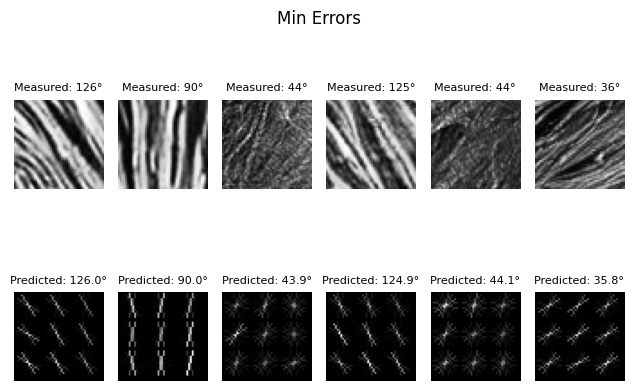

In [281]:
y_error= abs(y_pred-y_test)
y_error_sorted= np.sort(y_error)
no_pics= 6

fig, axs = plt.subplots(2, no_pics)

for i in np.arange(0, no_pics):
    i_max_error= np.where(y_error== y_error_sorted[i])[0]
    i_abs= i_test[i_max_error][0]

    print(f"Max error at i_abs= {i_abs}, measured: {y_test[i_max_error][0]}, predicted: {y_pred[i_max_error][0]:.2f}, error= {y_error_sorted[i]:.2f}")

    img_dir= img_directories[i_abs]
    img= cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    hog_features, hog_image = hog(img, orientations= 8, pixels_per_cell= (int(img.shape[0]/3), int(img.shape[1]/3)),
                        visualize=True, feature_vector= True)


    plt.subplot(2, no_pics, i+1)
    plt.imshow(img, cmap= "gray")
    plt.axis("off")
    plt.title(f"Measured: {y_test[i_max_error][0]}{chr(176)}", size= 8)

    plt.subplot(2, no_pics, i+1 + no_pics)
    plt.imshow(hog_image, cmap='gray')
    plt.axis("off")
    plt.title(f"Predicted: {y_pred[i_max_error][0]:.1f}{chr(176)}", size= 8)

plt.tight_layout()
plt.suptitle("Min Errors")

./pictures/por_image/1.png
./pictures/por_image/2.png
./pictures/por_image/3.png
./pictures/por_image/4.png
./pictures/por_image/5.png
./pictures/por_image/7.png
./pictures/por_image/8.png
./pictures/por_image/9.png


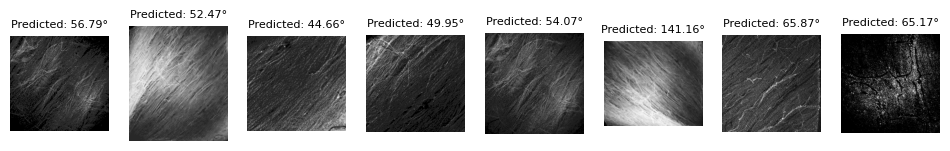

In [282]:
por_feature_matrix= []
por_img_directories= []

for i in range(1, 10):
    img_dir= "./pictures/por_image/" + str(i) + ".png"
    try:        
        feature_vec= get_feature_vector(img_dir, grid_q= 4, orientation= 10, edge= False)
        # feature_vec= get_feature_vector(img_dir, grid_q= np.arange(1, 5), orientation= 10, edge= False)
        por_feature_matrix.append(feature_vec)
        por_img_directories.append(img_dir)
    except:
        pass
clear_output()

por_feature_matrix= np.array(por_feature_matrix)
por_feature_matrix= scaler.transform(por_feature_matrix)
por_principle_matrix= pca_var.transform(por_feature_matrix)

por_prediction= model.predict(por_principle_matrix)

fig, axs= plt.subplots(1, len(por_img_directories), figsize= (12, 8))
for i, img_dir in enumerate(por_img_directories):
    print(img_dir)
    img= cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    hog_features, hog_image = hog(img, orientations= 8, pixels_per_cell= (int(img.shape[0]/4), int(img.shape[1]/4)),
                        visualize=True, feature_vector= True)

    plt.subplot(1, len(por_img_directories), i+1)
    plt.imshow(img, cmap= "gray")
    plt.axis("off")
    plt.title(f"Predicted: {por_prediction[i]:.2f}{chr(176)}", size= 8)
